## 1 正则化

在使用神经网络拟合数据时，有时候会出现过拟合现象，模型的泛化能力比较低。这时候就需要使用正则化来降低模型的复杂度，使得面对新数据时，能够有比较好的表现。

在讲解正则化之前，先介绍一些拟合数据时有可能会出现的“小插曲”：欠拟合和过拟合

### 1.1 欠拟合和过拟合

欠拟合，即模型不能有效拟合数据集，对现有数据集学习得不够彻底。

过拟合，即模型对当前数据拟合得太好，但对从未见过的数据缺乏泛化能力。

欠拟合的解决方法：
 + 增加特征项，给网络更多维度的输入特征
 + 扩展网络规模，增加网络深度，增加网络参数，提升模型的表达能力
 + 减少正则化参数
 
过拟合的解决方法：
 + 对数据进行清洗，减少数据集中的噪声，使数据集更纯净
 + 增大训练集，让模型见到更多的数据
 + 采用正则化
 + 增大正则化参数

### 1.2 正则化缓解过拟合

正则化项，也叫平滑项，在损失函数中引入模型复杂度指标，给每个参数 $w$ 增加权重，抑制训练数据集中的噪声，也就是说使用正则化项可以使得训练的函数对输入不敏感（如果输入数据有一定噪声的话，一个平滑的函数受到的影响会很小，反之若函数不平滑，那么对有噪声数据的预测不会有好结果）。

正则化一般只对参数 $w$ 使用，不对偏执 $b$ 使用，因为偏执 $b$ 只是影响函数的上下平移，并不影响函数的平滑程度。

使用正则化后，损失函数 loss 变成两部分的和：$$loss=loss(t, y) + REGULARIZER * loss(\omega)$$

 + 第一部分是以前求得的 loss 值，即预测结果和正确结果之间的差距，比如交叉熵、均方误差等
 + 第二部分中 $\omega$ 为需要正则化的参数，用超参数 REGULARIZER 给出参数 $\omega$ 在总 loss 中的比例，即正则化的权重
 
$loss(\omega)$ 的计算方式可以使用两种方法：L1 正则化和 L2 正则化
 + L1 正则化：对所有参数 $\omega$ 的绝对值求和：$loss_{L1}=\sum_i|\omega_i|$
  + L1 正则化大概率会使很多参数变为零，因此该方法可通过稀疏化参数，减少参数的数量，降低模型复杂度
 + L2 正则化：对所有参数 $\omega$ 的平方求和：$loss_{L2}=\sum_i|\omega_i^2|$
  + L2 正则化会使参数接近零但不为零，因此该方法可通过减少参数值的大小降低模型复杂度，可以有效缓解数据集中因噪声引起的过拟合

### 实践：正则化缓解过拟合

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/dot.csv')
df.head()

,x1,x2,y_c
0,-0.416758,-0.056267,1
1,-2.136196,1.640271,0
2,-1.793436,-0.841747,0
3,0.502881,-1.245288,1
4,-1.057952,-0.909008,1


读入数据集 `dot.csv` 中的数据，其中 `x1` 和 `x2` 是输入特征，`y_c` 是与特征相对应的标签。

现在的任务为：使用神经网络**拟合输入特征 `x1` 和 `x2` 与标签的关系**，模型训练好之后，将新的数据送入神经网络，神经网络会对新输入的数据进行预测，并判断其标签是 `0` 的可能性大还是 `1` 的可能性大。

为了便于观察，分别将 `x1` 和 `x2` 作为横纵坐标把数据可视化出来。所有标签为 1 的点标为红色，所有标签为 0 的点标为蓝色，让神经网络画出一条线区分红色点和蓝色点。

实现可视化这一步骤的思路大致为：
 + 先用神经网络拟合出输入特征 `x1` 和 `x2` 与标签的函数关系，然后生成网格并覆盖这些点
 + 把网格生成的交点，即交点的横纵坐标，作为输入送入训练好的神经网络
 + 神经网络会为每个坐标输出一个预测值
 + 要区分输出偏向 1 还是偏向 0，可以把神经网络输出的预测值为 0.5 的线标出颜色，这条线就是 0（蓝点）和 1（红点）的区分线


首先处理输入数据

In [3]:
x_data = np.array(df[['x1', 'x2']])
y_data = np.array(df['y_c'])
x_data[:10], y_data[:10]

(array([[-0.41675785, -0.05626683],
        [-2.1361961 ,  1.64027081],
        [-1.79343559, -0.84174737],
        [ 0.50288142, -1.24528809],
        [-1.05795222, -0.90900762],
        [ 0.55145404,  2.29220801],
        [ 0.04153939, -1.11792545],
        [ 0.53905832, -0.5961597 ],
        [-0.0191305 ,  1.17500122],
        [-0.74787095,  0.00902525]]),
 array([1, 0, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int64))

In [4]:
# 生成 x_train, y_train
# x_data 的列数为 2，行数为数据个数，不需要更改形状，如果不放行可以使用下面的注释代码
#x_train = np.vstack(x_data).reshape(-1, 2)
x_train = x_data
# y_data 不是二维的，因此为了便于使用，更改其维度
y_train = y_data.reshape(-1, 1)

# 转换 x 的数据类型，否则后面矩阵相乘时会因数据类型问题报错
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)
x_train[:10], y_train[:10]

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[-0.41675785, -0.05626683],
        [-2.1361961 ,  1.6402708 ],
        [-1.7934356 , -0.84174734],
        [ 0.5028814 , -1.2452881 ],
        [-1.0579522 , -0.9090076 ],
        [ 0.55145407,  2.292208  ],
        [ 0.04153939, -1.1179254 ],
        [ 0.5390583 , -0.5961597 ],
        [-0.0191305 ,  1.1750013 ],
        [-0.7478709 ,  0.00902525]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32)>)

In [5]:
# 生成颜色标签
Y_c = [['red' if y else 'blue' for y in y_train]]

In [6]:
# 将输入特征与标签进行对应，将数据拆开又合在一起是为了形成张量，便于之后的计算，并分批次读取（每批次 32 个数据）
# 并定义每次迭代的数据量为 32 个
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

定义神经网络超参数：定义输入层为 2 个神经元（因为输入特征只有两个），隐藏层只有 1 层并定义有 11 个神经元（该数值可以更换），输出层为 1 个神经元。

In [7]:
params = {
    'w1': tf.Variable(tf.random.normal([2, 11]), dtype=tf.float32),
    'b1': tf.Variable(tf.constant(0.01, shape=[11])),
    # 每层的输入节点数要与上一层的输出节点数保持一致
    'w2': tf.Variable(tf.random.normal([11, 1]), dtype=tf.float32),
    'b2': tf.Variable(tf.constant(0.01, shape=[1]))
}

实现训练函数：
 + train_db 为训练数据集
 + params 为神经网络的初始超参数
 + lr 学习率为 0.005
 + epoch 迭代次数为 800
 + regularizer 为正则化函数，默认为 None，表示当前的训练过程不包含正则化

In [8]:
def train(train_db, params, lr=0.005, epoch=800, regularizer=None):
    for i in range(epoch):
        for step, (x_train, y_train) in enumerate(train_db):
            with tf.GradientTape() as tape:
                # 隐藏层的乘加运算
                h1 = tf.matmul(x_train, params['w1']) + params['b1']
                # 隐藏层计算结果送入激活函数，结果为隐藏层输出
                h1 = tf.nn.relu(h1)
                # 隐藏成输出与输出层的权重和偏置进行乘加运算，得到的结果为神经网络的输出
                y = tf.matmul(h1, params['w2']) + params['b2']
                
                # 使用均方误差损失函数
                loss = tf.reduce_mean(tf.square(y_train - y))
                
                # 这里使用正则化，后面进行具体实现
                if regularizer:
                    loss = regularizer(loss, params['w1'], params['w2'])
                
            variables = [params['w1'], params['b1'], params['w2'], params['b2']]
            grads = tape.gradient(loss, variables)
            
            # 实现梯度更新
            params['w1'].assign_sub(lr *grads[0])
            params['b1'].assign_sub(lr *grads[1])
            params['w2'].assign_sub(lr *grads[2])
            params['b2'].assign_sub(lr *grads[3])
            
        # 每迭代 20 次，打印 loss 信息
        if i % 20 == 0:
            print('epoch: {}, loss: {}'.format(i, loss))

实现预测函数并可视化预测结果:
 + x_data 为输入特征，包含 `x1` 和 `x2`
 + Y_c 为正确结果的颜色标签
 + params 为训练后的神经网络参数

In [9]:
def predict(x_data, Y_c, params):
    # 生成网格坐标点
    # xx 在 -3 到 3 之间，步长为 0.1；yy 在 -3 到 3 之间，步长为 0.1
    xx, yy = np.mgrid[-3:3:0.1, -3:3:0.1]
    # 将 xx, yy 拉直（使用 .ravel() 函数），并合并配对为二维张量（使用 np.c_[]），生成二维坐标点
    grid = np.c_[xx.ravel(), yy.ravel()]
    # 转换数据类型，否则在之后的矩阵运算时会出错
    grid = tf.cast(grid, tf.float32)
    
    # 记录神经网络的所有输出
    probs = []
    for x_test in grid:
        # 使用训练好的参数进行训练,x_test 需要增加一个维度才能进行矩阵运算
        h1 = tf.matmul([x_test], params['w1']) + params['b1']
        h1 = tf.nn.relu(h1)
        y = tf.matmul(h1, params['w2']) + params['b2']
        probs.append(y)
        
    # 获取第 0 列给 x1， 第 1 列给 x2
    x1 = x_data[:, 0]
    x2 = x_data[:, 1]
    # probs 的 shape 调整为与 xx 一致
    probs = np.array(probs).reshape(xx.shape)
    # squeeze 去掉维度为 1 的维度,相当于去掉[['red'],['blue']], 内层括号变为 ['red','blue']
    plt.scatter(x1, x2, color=np.squeeze(Y_c)) 
    # 把坐标 xx, yy 和对应的值 probs 放入 contour 函数，给 probs 值为 0.5 的所有点上色 
    plt.contour(xx, yy, probs, levels=[.5])
    plt.show()

测试不包含正则化过程的拟合结果

epoch: 0, loss: 1.302331805229187
epoch: 20, loss: 0.1685471087694168
epoch: 40, loss: 0.09727684408426285
epoch: 60, loss: 0.07101770490407944
epoch: 80, loss: 0.05921752378344536
epoch: 100, loss: 0.05189155042171478
epoch: 120, loss: 0.04776528850197792
epoch: 140, loss: 0.043867114931344986
epoch: 160, loss: 0.04087772220373154
epoch: 180, loss: 0.038045916706323624
epoch: 200, loss: 0.03560646250844002
epoch: 220, loss: 0.03351364657282829
epoch: 240, loss: 0.03151651471853256
epoch: 260, loss: 0.02831781469285488
epoch: 280, loss: 0.025656552985310555
epoch: 300, loss: 0.023727253079414368
epoch: 320, loss: 0.022490426898002625
epoch: 340, loss: 0.02153913676738739
epoch: 360, loss: 0.02089998684823513
epoch: 380, loss: 0.020395733416080475
epoch: 400, loss: 0.019949981942772865
epoch: 420, loss: 0.019651765003800392
epoch: 440, loss: 0.0193940382450819
epoch: 460, loss: 0.019178681075572968
epoch: 480, loss: 0.019018234685063362
epoch: 500, loss: 0.018731294199824333
epoch: 520,

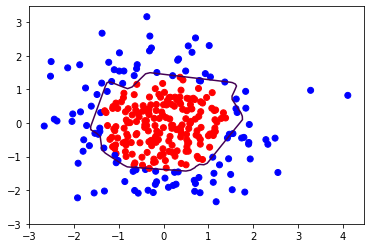

In [10]:
train(train_db, params)
predict(x_data, Y_c, params)

根据拟合图像可以发现，拟合曲线的轮廓不够平滑，存在过拟合现象。因此，可以使用正则化来缓解过拟合现象。

下面实现正则化过程，使用 L2 正则化。

In [11]:
def L2(loss, w1, w2):
    REGULARIZER = 0.03
    loss_regularization = []
    # tf.nn.l2_loss(w) = sum(w ** 2) / 2
    loss_regularization.append(tf.nn.l2_loss(w1))
    loss_regularization.append(tf.nn.l2_loss(w2))
    loss_regularization = tf.reduce_sum(loss_regularization)
    return loss + REGULARIZER * loss_regularization

epoch: 0, loss: 0.24250410497188568
epoch: 20, loss: 0.22989575564861298
epoch: 40, loss: 0.21855877339839935
epoch: 60, loss: 0.20806244015693665
epoch: 80, loss: 0.19830629229545593
epoch: 100, loss: 0.18932919204235077
epoch: 120, loss: 0.18091441690921783
epoch: 140, loss: 0.1730489730834961
epoch: 160, loss: 0.16566775739192963
epoch: 180, loss: 0.15898948907852173
epoch: 200, loss: 0.15280888974666595
epoch: 220, loss: 0.1469685137271881
epoch: 240, loss: 0.1412762999534607
epoch: 260, loss: 0.13597160577774048
epoch: 280, loss: 0.13102684915065765
epoch: 300, loss: 0.12663868069648743
epoch: 320, loss: 0.12245367467403412
epoch: 340, loss: 0.1184590756893158
epoch: 360, loss: 0.11473483592271805
epoch: 380, loss: 0.11114314943552017
epoch: 400, loss: 0.10785649716854095
epoch: 420, loss: 0.10485795140266418
epoch: 440, loss: 0.10232564806938171
epoch: 460, loss: 0.09993195533752441
epoch: 480, loss: 0.09757822751998901
epoch: 500, loss: 0.09532184898853302
epoch: 520, loss: 0.09

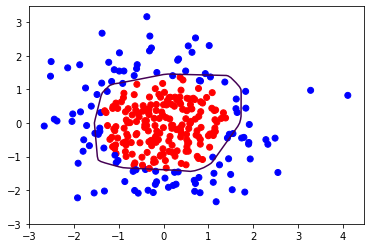

In [12]:
train(train_db, params, regularizer=L2)
predict(x_data, Y_c, params)

由图片可以看出，加入 L2 正则化后的曲线更平缓，有效缓解了过拟合